In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pickle import load,dump
from numpy import array
import traceback

In [2]:
PATH = "data/Flickr8k_text/"
# opening text file
with open(PATH + "Flickr8k.lemma.token.txt") as f:
    data = f.read()


In [3]:
descriptions = dict()
worddata = pd.Series([1],[" "])

In [4]:
for el in data.split("\n"):
        tokens = el.split()
        image_id , image_desc = tokens[0],tokens[1:]

        # dropping .jpg from image id
        image_id = image_id.split(".")[0]

        image_desc = " ".join(image_desc)

        # check if image_id is already present or not
        if image_id in descriptions:
            descriptions[image_id].append(image_desc)
        else:
            descriptions[image_id] = list()
            descriptions[image_id].append(image_desc)


In [5]:
descriptions["1019604187_d087bf9a5f"]

['A dog prepare to catch a throw object in a field with nearby car .',
 'A white dog be about to catch a yellow ball in its mouth .',
 'A white dog be about to catch a yellow dog toy .',
 'A white dog be ready to catch a yellow ball fly through the air .',
 'A white dog run after a yellow ball']

In [6]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [7]:
b = {}
for k in descriptions.keys():
    value = descriptions[k]
    caption_list = []
    for ec in value:
        # replaces specific and general phrases
        sent = decontracted(ec)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        
        wordlist = list(sent.lower().split(" "))
        for word in wordlist:
            if(word != ''):
                if(word in b):
                    b[word] = b[word] + 1
                else:
                    b[word] = 1
        image_cap = 'startseq ' + sent.lower() + ' endseq'
        caption_list.append(image_cap)
    descriptions[k] = caption_list
worddata = pd.Series(b)

In [8]:
descriptions["1019604187_d087bf9a5f"]

['startseq a dog prepare to catch a throw object in a field with nearby car  endseq',
 'startseq a white dog be about to catch a yellow ball in its mouth  endseq',
 'startseq a white dog be about to catch a yellow dog toy  endseq',
 'startseq a white dog be ready to catch a yellow ball fly through the air  endseq',
 'startseq a white dog run after a yellow ball endseq']

In [9]:
worddata.to_csv('wordcountlemma.csv')

<AxesSubplot:>

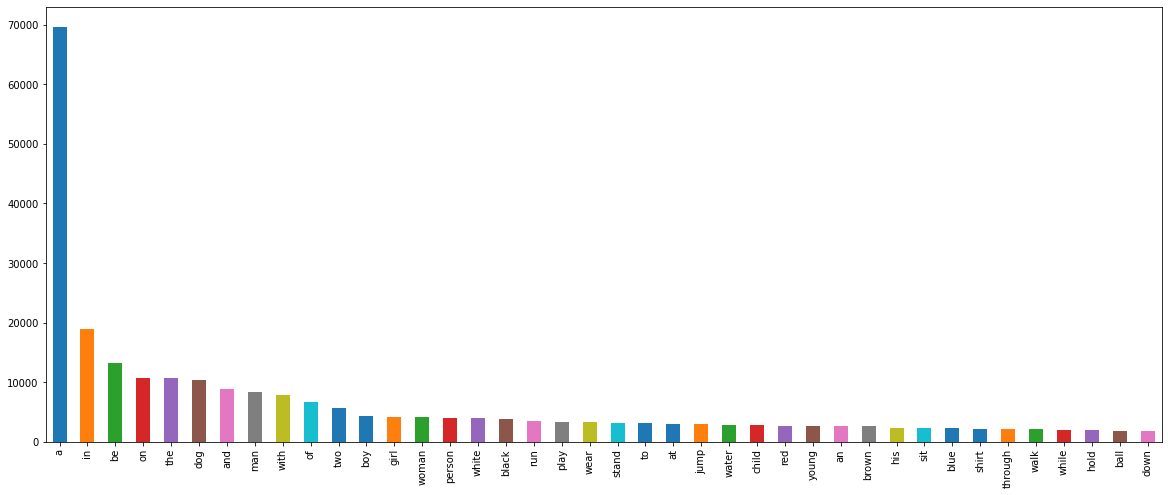

In [10]:
sortedData = worddata.sort_values(ascending=False)
sortedData.head(40).plot.bar(figsize=(20,8))

In [18]:
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.layers import Dense,BatchNormalization,Dropout,Embedding,RepeatVector
from keras.preprocessing.image import load_img, img_to_array

from keras.models import Sequential
from keras.models import Model

In [23]:
inception = InceptionV3(weights='imagenet')
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 149, 149, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [36]:
inception._layers.pop()

for layer in inception.layers:
    layer.trainable = False

In [38]:
final_model = Model(inputs = inception.input , outputs = inception.layers[-1].output)
final_model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 149, 149, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_188[0][0]    
______________________________________________________________________________________

In [40]:
TARGET_SIZE = (299,299)

In [42]:
img = load_img("data/Flicker8k_Dataset/1019604187_d087bf9a5f.jpg",target_size=TARGET_SIZE)
img_array = img_to_array(img)
nimage = preprocess_input(img_array)
# Adding one more dimesion
nimage = np.expand_dims(nimage, axis=0)    
fea_vec = final_model.predict(nimage)
train_image_extracted = np.reshape(fea_vec, fea_vec.shape[1])

In [ ]:
plt.imshow(img)

In [ ]:
print(fea_vec[0].shape)

In [ ]:
plt.matshow(fea_vec[0], cmap='viridis')

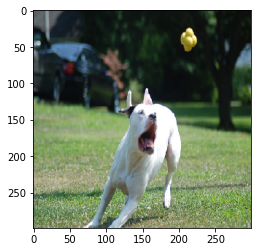

In [46]:
print(fea_vec[0].shape)

(2048,)


In [55]:
plt.matshow(fea_vec[0], cmap='viridis')

ValueError: not enough values to unpack (expected 2, got 1)